## 1. Combining Spatial Enhancement Methods

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

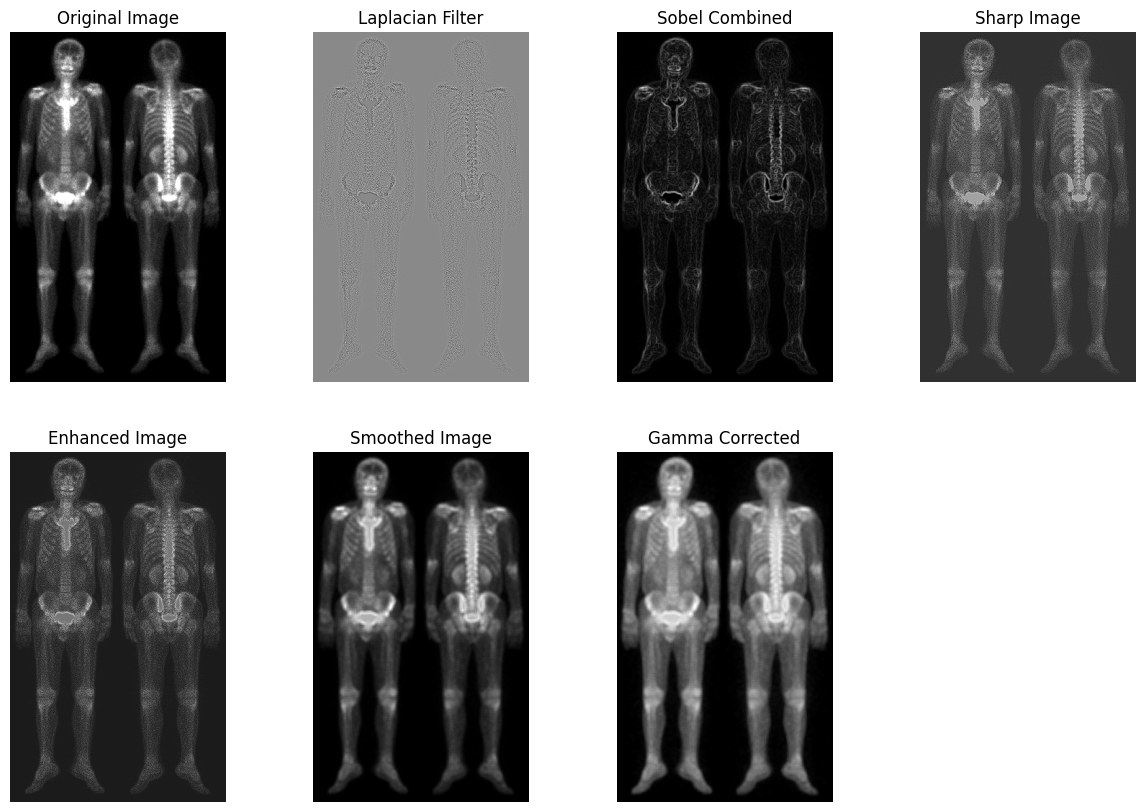

True

In [6]:
# Đọc ảnh đầu vào
image = cv2.imread('bone_scan.jpg', cv2.IMREAD_GRAYSCALE)

# 1. Áp dụng bộ lọc Laplacian để làm sắc nét ảnh
laplacian = cv2.Laplacian(image, cv2.CV_64F)
sharp_image = cv2.subtract(image.astype(np.float64), laplacian)

# 2. Áp dụng bộ lọc Sobel để phát hiện biên
sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
sobel_combined = cv2.magnitude(sobel_x, sobel_y)

# 3. Kết hợp các ảnh để tạo hình ảnh nâng cao
enhanced_image = cv2.addWeighted(sharp_image, 0.7, sobel_combined, 0.3, 0)

# 4. Làm mượt ảnh bằng bộ lọc trung bình (5x5)
smoothed_image = cv2.blur(enhanced_image, (5, 5))

# 5. Áp dụng chuyển đổi power-law (gamma correction)
gamma = 0.5
gamma_corrected = np.array(255 * (smoothed_image / 255) ** gamma, dtype='uint8')

# Hiển thị các kết quả
titles = ['Original Image', 'Laplacian Filter', 'Sobel Combined', 'Sharp Image', 
          'Enhanced Image', 'Smoothed Image', 'Gamma Corrected']
images = [image, laplacian, sobel_combined, sharp_image, 
          enhanced_image, smoothed_image, gamma_corrected]

plt.figure(figsize=(15, 10))
for i in range(7):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.show()

# Lưu ảnh kết quả
cv2.imwrite('laplacian.jpg', laplacian)
cv2.imwrite('sharp_image.jpg', sharp_image)
cv2.imwrite('sobel_combined.jpg', sobel_combined)
cv2.imwrite('enhanced_image.jpg', enhanced_image)
cv2.imwrite('smoothed_image.jpg', smoothed_image)
cv2.imwrite('gamma_corrected.jpg', gamma_corrected)


## 2. Find Contours Function

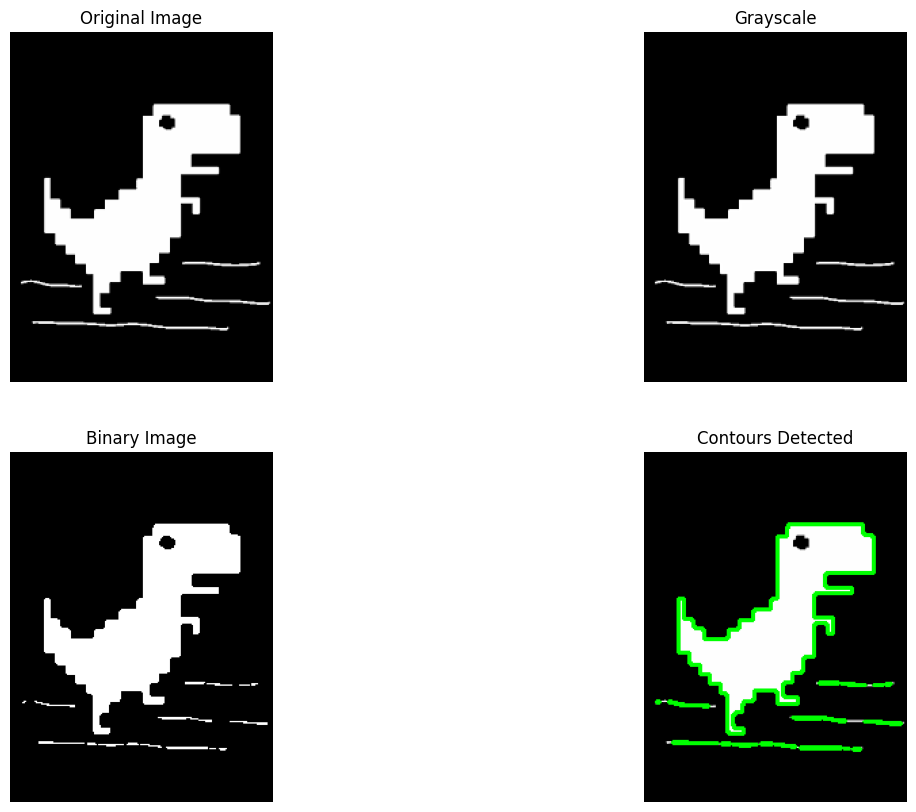

True

In [9]:
# 1. Đọc ảnh đầu vào
image = cv2.imread('khunglong.jpg')
if image is None:
    raise FileNotFoundError("The image file 'khunglong.jpg' was not found.")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 2. Làm mờ ảnh để giảm nhiễu
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# 3. Áp dụng ngưỡng để chuyển đổi thành ảnh nhị phân
_, binary = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)

# 4. Tìm các đường viền (contours) trong ảnh nhị phân
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Vẽ các đường viền tìm được lên ảnh gốc
output_image = image.copy()
cv2.drawContours(output_image, contours, -1, (0, 255, 0), 2)

# Hiển thị các kết quả
titles = ['Original Image', 'Grayscale', 'Binary Image', 'Contours Detected']
images = [image, gray, binary, output_image]

plt.figure(figsize=(15, 10))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB) if i == 0 or i == 3 else images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.show()

# Lưu ảnh kết quả
cv2.imwrite('contours_detected.jpg', output_image)


## 3. Dice Recognition


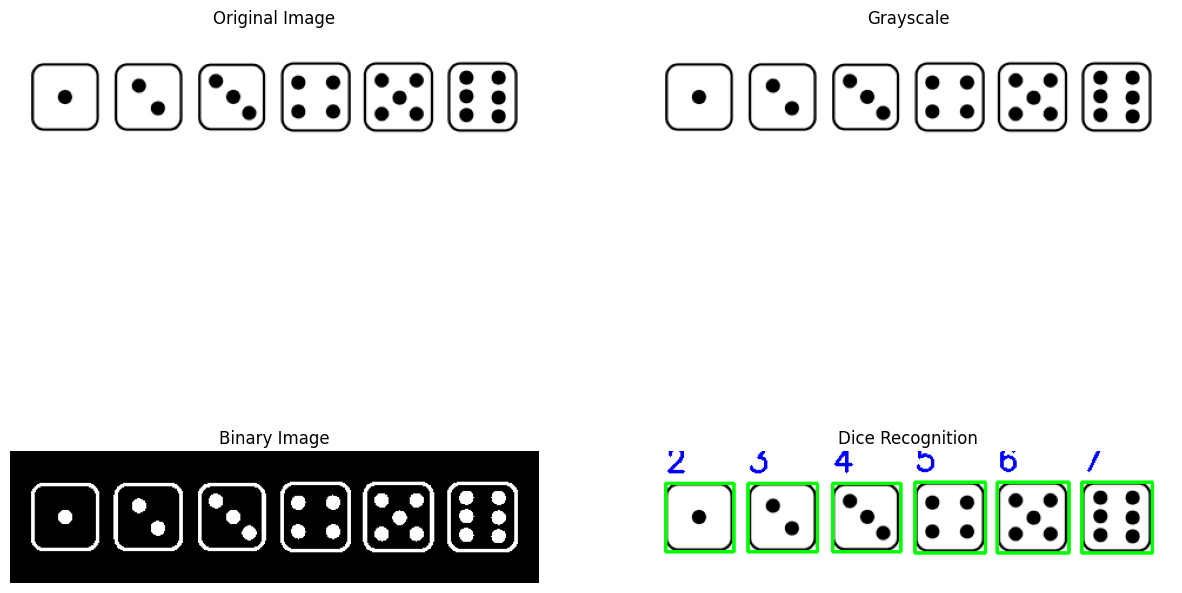

Số lượng chấm trên mỗi viên xúc xắc: [4, 3, 2, 7, 6, 5]


True

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Đọc ảnh đầu vào
image = cv2.imread('dice_image.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 2. Làm mờ ảnh để giảm nhiễu và áp dụng ngưỡng thích ứng
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 11, 2)

# 3. Tìm các đường viền (contours) để phát hiện các viên xúc xắc
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Biến để lưu số lượng chấm của từng viên xúc xắc
dice_counts = []

# Duyệt qua từng viên xúc xắc phát hiện được
for contour in contours:
    # Bỏ qua các đường viền nhỏ (nhiễu)
    if cv2.contourArea(contour) < 1000:
        continue

    # Tạo bounding box để giới hạn từng viên xúc xắc
    x, y, w, h = cv2.boundingRect(contour)
    roi = binary[y:y + h, x:x + w]

    # Tìm các chấm trong vùng ROI bằng phương pháp connected components
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(roi, connectivity=8)
    
    # Đếm số chấm, bỏ qua background (label = 0) và các vùng quá nhỏ
    num_dots = 0
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= 30:  # Ngưỡng diện tích nhỏ nhất cho một chấm hợp lệ
            num_dots += 1
    
    dice_counts.append(num_dots)

    # Vẽ khung giới hạn và số chấm phát hiện được lên ảnh gốc
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image, str(num_dots), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

# Hiển thị các kết quả
titles = ['Original Image', 'Grayscale', 'Binary Image', 'Dice Recognition']
images = [cv2.imread('dice_image.jpg'), gray, binary, image]

plt.figure(figsize=(15, 10))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB) if i == 0 or i == 3 else images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.show()

# In ra kết quả số lượng chấm trên từng viên xúc xắc
print("Số lượng chấm trên mỗi viên xúc xắc:", dice_counts)

# Lưu ảnh kết quả
cv2.imwrite('dice_recognition_result.jpg', image)
